# 實作VGG16 convolutional base 卷積基底


In [1]:
#導入VGG架構
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights = 'imagenet', #初始化model的權重
                 include_top = False,  #不使用Dense層, 自建密集分類器 用於 - 貓跟狗
                 input_shape = (150,150,3))

conv_base.summary()

58892288/58889256 [==============================] - 6s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

## 方法1 沒有資料擴增的快速特徵萃取

In [6]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_dir = './cats_and_dogs_small'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale = 1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape = (sample_count, 4, 4, 512)) # VGG 捲基層的輸出為(4,4,512)
    labels = np.zeros(shape = (sample_count))
    generator = datagen.flow_from_directory(directory,
                                            target_size = (150, 150),
                                           batch_size = batch_size,
                                           class_mode = 'binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1)* batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        print(i, end = ' ') #萃取時間較久, 所以印出i 來察看進度
        
        if i * batch_size >= sample_count:
            break #產生器會無限產生影像資料,所以在每個影像被萃取過特徵後,就執行break
    
    return features, labels

train_feautres, train_labels = extract_features(train_dir, 2000) #樣本數
validation_features, valiation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 Found 1000 images belonging to 2 classes.
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 Found 1000 images belonging to 2 classes.
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 

In [10]:
#為了要傳輸到密集層, 需要先把資料攤平
print('before:train_feautres', train_feautres.shape)

train_feautres = np.reshape(train_feautres, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_feautres = np.reshape(test_features, (1000, 4*4*512))

print('after:train_feautres', train_feautres.shape)

before:train_feautres (2000, 8192)
after:train_feautres (2000, 8192)


In [11]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation = 'relu', input_dim = 4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation = 'sigmoid'))

model.compile(optimizer = optimizers.RMSprop(lr = 2e-5),
             loss = 'binary_crossentropy',
             metrics = ['acc'])

history = model.fit(train_feautres, train_labels,
                   epochs = 30,
                   batch_size = 20,
                   validation_data = (validation_features, valiation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 1s 467us/sample - loss: 0.6413 - acc: 0.6410 - val_loss: 0.4489 - val_acc: 0.8440
Epoch 2/30
2000/2000 [==============================] - 0s 145us/sample - loss: 0.4429 - acc: 0.7955 - val_loss: 0.3687 - val_acc: 0.8650
Epoch 3/30
2000/2000 [==============================] - 0s 141us/sample - loss: 0.3704 - acc: 0.8370 - val_loss: 0.3303 - val_acc: 0.8770
Epoch 4/30
2000/2000 [==============================] - 0s 141us/sample - loss: 0.3262 - acc: 0.8675 - val_loss: 0.3062 - val_acc: 0.8840
Epoch 5/30
2000/2000 [==============================] - 0s 143us/sample - loss: 0.3012 - acc: 0.8795 - val_loss: 0.2972 - val_acc: 0.8730
Epoch 6/30
2000/2000 [==============================] - 0s 140us/sample - loss: 0.2720 - acc: 0.8985 - val_loss: 0.2757 - val_acc: 0.8950
Epoch 7/30
2000/2000 [==============================] - 0s 140us/sample - loss: 0.2474 - acc: 0.9020 - val_loss: 0.2680 - va

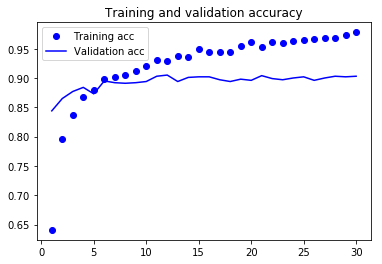

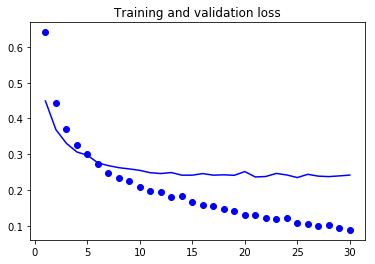

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)


plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b',label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()


plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')

plt.show()